## Exploring Malaria Simulation Output Data

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import shutil

# Some base data
strategies = ['AL5',
              'AL4',
              'AL25-ASAQ75',
              'AL25-DHAPPQ75',
              'AL50-ASAQ50',
              'AL50-DHAPPQ50',
              'AL75-ASAQ25',
              'AL75-DHAPPQ25',
              'ASAQ',
              'ASAQ25-DHAPPQ75',
              'ASAQ50-DHAPPQ50',
              'ASAQ75-DHAPPQ25',
              'DHA-PPQ',
              'status_quo',
              'DHA-PPQ_3yrs_then_5day_AL50-ASAQ50',
              'DHA-PPQ_3yrs_then_AL50-DHAPPQ50',
              ]

table_names = ['monthlydata', 'sqlite_sequence', 'monthlysitedata', 'genotype', 'monthlygenomedata']

# Database tools -----------------------------------------------------------------------------
def get_all_tables(db: str) -> list:
    """
    Get all tables in a sqlite3 database

    Args:
    db (str): path to sqlite3 database

    Returns:
    list: list of tables in the database
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        c = conn.cursor()
        c.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = c.fetchall()
    
    return [table[0] for table in tables]

def get_table(db: str, table: str) -> pd.DataFrame:
    """
    Get a table from a sqlite3 database

    Args:
    db (str): path to sqlite3 database
    table (str): name of table to get

    Returns:
    pd.DataFrame: table as a pandas DataFrame
    """
    # Validate input file path
    if not os.path.exists(db):
        raise FileNotFoundError(f"File not found: {db}")
    with sqlite3.connect(db) as conn:
        df = pd.read_sql_query(f"SELECT * FROM {table}", conn)
    
    return df

# Data analysis tools -----------------------------------------------------------------------
def calculate_treatment_failure_rate(data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate treatment failures for a given table

    Args:
    data (DataFrame): monthlysitedata table to calculate treatment failures

    Returns:
    pd.DataFrame: table with treatment failures
    """
    # Calculate treatment failures
    data['failure_rate'] = data['treatmentfailures'] / data['treatments']
    return data

#def aggregate_monthlysitedata(path: str, strategy: str, locationid: int = 0) -> pd.DataFrame:
def aggregate_failure_rates(path: str, strategy: str, locationid: int = 0) -> pd.DataFrame:
    """
    Aggregate failure rate data by strategy. This function searchs path for all the result 
    files for the given strategy and aggregates them.

    Args:
    path (str): path to search for result files
    strategy (str): strategy to aggregate data for
    locationid (int): locationid to filter by, defaults to 0 which returns all locations

    Returns:
    pd.DataFrame: aggregated data
    pd.Series: monthlydataid column
    """
    # Get all files for the strategy
    files = glob.glob(os.path.join(f"{path}", f"{strategy}_*.db"))
    if len(files) == 0:
        print(f"No files found for strategy {strategy} in {path}")
        return
    else:
        print(f"Aggregating data for strategy {strategy} with {len(files)} files")
    summary = pd.DataFrame()
    for file in files:
        data = get_table(file, 'monthlysitedata')
        data = calculate_treatment_failure_rate(data)
        if locationid > 0:
            data = data[data["locationid"] == locationid]
        months = data['monthlydataid'].unique()
        locations = data['locationid'].unique()
        data_summary = pd.DataFrame(index=months, columns=locations)
        for location in locations:
            location = int(location)
            failures = data.loc[data['locationid'] == location, ['monthlydataid', 'failure_rate']]
            failures.index = failures['monthlydataid']
            data_summary[location] = failures['failure_rate']
        if locationid > 0:
            summary[file] = data_summary.sum(axis=1)
        else:
            summary[file] = data_summary.mean(axis=1)
    summary['mean'] = summary.mean(axis=1)
    summary['median'] = summary.median(axis=1)
    summary['95th'] = summary.quantile(axis=1, q=0.95)
    summary['5th'] = summary.quantile(axis=1, q=0.05)
    return summary

def save_aggregated_data(monthlysitedata: dict[str, pd.DataFrame], monthlydataid: pd.Series, strategy: str, path: str):
    """
    Save aggregated data to a file

    Args:
    monthlysitedata (dict[str, pd.DataFrame]): aggregated data
    monthlydataid (pd.Series): monthlydataid column
    strategy (str): strategy
    path (str): path to save the file
    """
    with sqlite3.connect(os.path.join(path, f"{strategy}_aggregated.db")) as conn:
        for column in monthlysitedata.keys():
            monthlysitedata[column].to_sql(column, conn, index=False)
        monthlydataid.to_sql('monthlydataid', conn, index=False)

def plot_strategy_treatment_failure(data: pd.DataFrame, strategy: str, figsize: tuple = (18, 3)):
    """
    Plot treatment failure rate for a given strategy

    Args:
        data (pd.DataFrame): treatement failure data to plot from aggregate_failure_rates
        months (pd.DataFrame): months for the data
        strategy (str): strategy to plot
        figsize (tuple): figure size
    
    Returns:    
        tuple: figure and axis
    """
    fig, ax = plt.subplots(figsize=figsize)
    #ax.plot(months / 12, data['failure_rate']['mean'], label='Mean')
    ax.plot(data.index / 12, data['median'], label='Median')
    ax.fill_between(data['median'].index / 12, 
                    data['5th'], 
                    data['95th'], color='b', alpha=0.15, label='5th-95th percentile')
    ax.axhline(y=0.1, color='r', linestyle='--', label='10% threshold')
    ax.set_title(f"{strategy} Treatment Failure Rate")
    ax.set_xlabel("Years")
    ax.set_ylabel("Treatment Failure Rate")
    ax.legend()
    return fig, ax

def get_population_data(file: str, month: int = -1) -> pd.DataFrame:
    """
    Get the population data for a given file and month

    Args:
    file (str): path to sqlite3 database
    month (int): month to filter by, defaults to -1 which returns the last month

    Returns:
    pd.DataFrame: population data
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    population_data = get_table(file, 'monthlysitedata')
    if month > 0:
        population_data = population_data.loc[population_data['monthlydataid'] == month]
    else:
        last_month = population_data.iloc[-1]['monthlydataid']
        population_data = population_data.loc[population_data['monthlydataid'] == last_month]
    population_data = population_data[['locationid', 'population', 'infectedindividuals']]
    population_data.index = population_data['locationid']
    population_data = population_data.drop(columns='locationid')
    return population_data

def get_genome_data(file: str, month: int = -1) -> pd.DataFrame:
    """
    Get the genome data for a given file and month

    Args:
    file (str): path to sqlite3 database
    month (int): month to filter by, defaults to -1 which returns the last month

    Returns:
    pd.DataFrame: genome data
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    genome_data = get_table(file, 'monthlygenomedata')
    if len(genome_data) == 0:
        raise ValueError(f"No genome data found in {file}")    
    if month > 0:
        genome_data = genome_data.loc[genome_data['monthlydataid'] == month]
    else:
        last_month = genome_data.iloc[-1]['monthlydataid']
        genome_data = genome_data.loc[genome_data['monthlydataid'] == last_month]
    genome_data = genome_data[['locationid', 'genomeid', 'occurrences', 'weightedoccurrences']]
    genome_data.index = genome_data['locationid']
    genome_data = genome_data.drop(columns='locationid')
    return genome_data

def calculate_genome_frequencies(file: str, month: int = -1) -> pd.DataFrame:
    """
    Calculate the genome frequencies

    Args:
    file (str): path to sqlite3 database
    month (int): month to filter by, defaults to -1 which returns the last month

    Returns:
    pd.DataFrame: genome frequency data
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    # Get the genomes
    genomes = get_table(file, 'genotype')
    # Get the genome data
    genome_data = get_genome_data(file, month)
    # Get the population data
    population_data = get_population_data(file, month)
    # Calculate the genome frequencies
    genome_frequencies = pd.DataFrame(index=population_data.index, columns=genomes['id'].to_list())
    totals = []
    for genome in genomes['id'].to_list():
        occurrences = genome_data.loc[genome_data['genomeid'] == genome, ['occurrences']]
        occurrences = occurrences.join(population_data, how='outer').fillna(0)
        genome_frequencies[genome] = occurrences['occurrences'] / occurrences['population']
        totals.append(occurrences['occurrences'].sum() / occurrences['population'].sum())
    genome_frequencies.loc['totals'] = totals
    return genome_frequencies

def get_resistant_genotypes(genomes: pd.DataFrame, allele: str) -> pd.DataFrame:
    """
    Get the genotypes that are resistant to an arbitrary drug by selecting
    genotypes that contain the allele that confers resistance.

    Args:
    genomes (pd.DataFrame): genotype data
    allele (str): allele to filter by

    Returns:
    pd.DataFrame: resistant genotypes
    """
    resistant_genotypes = genomes.loc[genomes['name'].str.contains(allele)]
    return resistant_genotypes

def calculate_resistant_genome_frequencies(file: str, allele: str, month: int = 0, locationid: int = -1) -> float:
    """
    Calculate the frequency or prevelance of drug resistant genotypes based on the presence of an allele that confers resistance.

    Args:
    file (str): path to sqlite3 database
    allele (str): allele to filter by, defaults to 'H'
    month (int): month to filter by, defaults to -1 which returns the last month
    locationid (int): locationid to filter by, defaults to -1 which returns all locations
    
    Returns:
    float: resistant genome prevelance
    """
    # Assert the file exists
    if not os.path.exists(file):
        raise FileNotFoundError(f"File not found: {file}")
    genomes = get_table(file, 'genotype')
    resistant_genotypes = genomes.loc[genomes['name'].str.contains(allele)]
    pop = get_table(file, 'monthlysitedata')
    parasite = get_table(file, 'monthlygenomedata')
    fqy = pop[['monthlydataid', 'locationid', 'population', 'infectedindividuals']].merge(parasite[['monthlydataid', 'locationid', 'genomeid', 'occurrences', 'weightedoccurrences']], on=['monthlydataid','locationid']).fillna(0)
    fqy['frequency'] = fqy['weightedoccurrences'] / fqy['infectedindividuals']
    # resistant_genome_data = genome_data[genome_data['genomeid'].isin(resistant_genotypes['id'])]
    fqy = fqy[fqy['genomeid'].isin(resistant_genotypes['id'])]
    if locationid > 0:
        fqy = fqy[fqy['locationid'] == locationid]
    if month > 0:
        fqy = fqy[fqy['monthlydataid'] == month]
    elif month == 0:
        fqy = fqy[fqy['monthlydataid'] == fqy['monthlydataid'].max()]
    return fqy

def aggregate_resistant_genome_frequencies(path: str, strategy: str, allele: str = 'H', month: int = -1, locationid: int = -1) -> list:
    """
    Aggregate genome frequencies for a given strategy

    Args:
    path (str): path to search for result files
    strategy (str): strategy to aggregate data for
    locationid (int): locationid to filter by

    Returns:
    list: aggregated genome frequencies
    """
    # Get all files for the strategy
    files = glob.glob(os.path.join(f"{path}", f"{strategy}_*.db"))
    if len(files) == 0:
        print(f"No files found for strategy {strategy} in {path}")
        return
    else:
        print(f"Aggregating data for strategy {strategy} with {len(files)} files")
    # Get the monthlysitedata table for the first file to set up aggregated data
    genome_frequencies = [] #pd.DataFrame() 
    # Aggregate data for the rest of the files
    for file in files:
        print(f"Aggregating data for {file}")
        #data = calculate_genome_frequencies(file)
        try:
            fqy = calculate_resistant_genome_frequencies(file, allele, month, locationid)
        except TypeError as e:
            print(e)
            continue
        except FileNotFoundError as e:
            print(e)
            continue
        except IndexError as e:
            print(e)
            print(f"Length of data: {len(genome_frequencies)}")
            continue
        except ValueError as e:
            print(e)
            continue
        if len(fqy) > 0:
            #genome_frequencies.append(fqy)
            if locationid > 0:
                genome_frequencies.append(fqy['frequency'].sum())
            else:
                genome_frequencies.append(fqy)                
    return genome_frequencies

def aggregate_resistant_genome_frequencies_by_month(path: str, strategy: str, allele: str = 'H', locationid: int = -1) -> pd.DataFrame:
    """
    Aggregate genome frequencies for a given strategy on a monthly basis for a time-series analysis

    Args:
    path (str): path to search for result files
    strategy (str): strategy to aggregate data for
    locationid (int): locationid to filter by, defaults to -1 which returns all locations

    Returns:
    DataFrame: aggregated genome frequencies
    """
    files = glob.glob(os.path.join(f"{path}", f"{strategy}_*.db"))
    if len(files) == 0:
        print(f"No files found for strategy {strategy} in {path}")
        return
    else:
        print(f"Aggregating data for strategy {strategy} with {len(files)} files")

    months = get_table(files[0], 'monthlydata')['id']
    genome_frequencies = pd.DataFrame(index=months)
    for file in files:
        fqy = calculate_resistant_genome_frequencies(file, allele, -1, locationid)
        fqy = fqy.groupby('monthlydataid')['frequency'].sum()
        genome_frequencies[file] = fqy
    
    genome_frequencies['mean'] = genome_frequencies.mean(axis=1)
    genome_frequencies['median'] = genome_frequencies.median(axis=1)
    genome_frequencies['95th'] = genome_frequencies.quantile(axis=1, q=0.95)
    genome_frequencies['5th'] = genome_frequencies.quantile(axis=1, q=0.05)
    
    return genome_frequencies

def plot_strategy_results(path: str, strategy: str, locationid:int = 0) -> plt.Figure:
    """
    Plots the treatment failure rate for a given strategy. If locationid is provided, only that location is plotted.
    If more than one results file is found in the path, the data is aggregated.

    Args:
    path (str): path to directory containing results files
    strategy (str): strategy to plot
    locationid (int): locationid to filter by

    Returns:
    plt.Figure: matplotlib figure
    """
    # Assert that the location is valid
    if locationid < 0:
        raise ValueError("locationid must be a positive integer")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    # Get all results files in the path
    results_files = glob.glob(os.path.join(path, f"{strategy}_.db"))
    if len(results_files) == 0:
        raise FileNotFoundError(f"No results files found for strategy {strategy}")
    # Read all results files
    failures = pd.DataFrame()
    for file in results_files:
        data = get_table(file, 'monthlysitedata')
        data = calculate_treatment_failure_rate(data, locationid)
        failures[file] = data['failure_rate']
        
    if locationid > 0:
        failures = failures.loc[failures['locationid'] == locationid]
    # else, aggregate all locations by taking the mean of the failure rates at each month
    else:
        months = failures['monthlydataid'].unique()
        monthly_average = pd.DataFrame()
        for month in months:
            monthly_data = failures.loc[failures['monthlydataid'] == month]
            monthly_average[month, 'population'] = monthly_data['population'].sum()
            monthly_average[month, 'treatments'] = monthly_data['treatments'].sum()
            monthly_average[month, 'treatmentfailures'] = monthly_data['treatmentfailures'].sum()
            monthly_average[month, 'failure_rate'] = monthly_data['failure_rate'].mean()

    failures['mean'] = failures.mean(axis=1)
    fig, ax = plt.subplots()
    ax.plot(failures['monthlydataid'])

In [2]:
#DATA_ROOT: str = os.path.join("G:\\", "My Drive")
DATA_ROOT: str = os.path.join("/", "home", "james", "Code", "Temple-Malaria-Simulation-Analysis")
#DATA_SOURCE: str = os.path.join(DATA_ROOT, "Code", "output_old")
DATA_SOURCE: str = os.path.join(DATA_ROOT, "output2", "rwa")
filelist = glob.glob(os.path.join(DATA_SOURCE, "*.db"))

Prefilter the data to clear out runs that didn't complete

In [3]:
for file in filelist:
    months = get_table(file, 'monthlydata')
    try:
        last_month = months['id'].to_list()[-1]
    except IndexError:
        print(f"File: {file} is missing data")
        continue
    if last_month < 385:
        print(f"File: {file} is missing data for month {last_month}")
        continue
    # move the file to the correct location
    shutil.move(file, os.path.join("good", os.path.basename(file)))

File: /home/james/Code/Temple-Malaria-Simulation-Analysis/output2/rwa/AL25-DHAPPQ75_46_run_46_monthly_data_0.db is missing data for month 116
File: /home/james/Code/Temple-Malaria-Simulation-Analysis/output2/rwa/AL75-ASAQ25_25_run_25_monthly_data_0.db is missing data for month 51
File: /home/james/Code/Temple-Malaria-Simulation-Analysis/output2/rwa/ASAQ_3_run_3_monthly_data_0.db is missing data for month 55
File: /home/james/Code/Temple-Malaria-Simulation-Analysis/output2/rwa/AL50-DHAPPQ50_21_run_21_monthly_data_0.db is missing data for month 53
File: /home/james/Code/Temple-Malaria-Simulation-Analysis/output2/rwa/AL75-DHAPPQ25_29_run_29_monthly_data_0.db is missing data
File: /home/james/Code/Temple-Malaria-Simulation-Analysis/output2/rwa/ASAQ25-DHAPPQ75_33_run_33_monthly_data_0.db is missing data for month 1
File: /home/james/Code/Temple-Malaria-Simulation-Analysis/output2/rwa/AL4_19_run_19_monthly_data_0.db is missing data for month 75
File: /home/james/Code/Temple-Malaria-Simulatio

In [4]:
# Create treatment failure plots for all strategies
# Note: due to incomplete batch runs, some strategies may not have data or have incomplete data
# Incomplete data will result in a ValueError when plotting due to a dimension mismatch

DATA_SOURCE: str = os.path.join(DATA_ROOT, "good")

for strategy in strategies:
    try:
        data = aggregate_failure_rates(DATA_SOURCE, strategy)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    if data is None:
        print(f"No data found for {strategy} or there was an aggregation error")
        continue
    try:
        fig, ax = plot_strategy_treatment_failure(data, strategy.replace("_", " ").title())
    except ValueError as e:
        print(e)
        plt.close(fig)
        continue
    plt.savefig(f"{strategy}.png")
    plt.close(fig)

Aggregating data for strategy AL5 with 45 files
Aggregating data for strategy AL4 with 45 files
Aggregating data for strategy AL25-ASAQ75 with 41 files
Aggregating data for strategy AL25-DHAPPQ75 with 45 files
Aggregating data for strategy AL50-ASAQ50 with 45 files
Aggregating data for strategy AL50-DHAPPQ50 with 45 files
Aggregating data for strategy AL75-ASAQ25 with 45 files
Aggregating data for strategy AL75-DHAPPQ25 with 45 files
Aggregating data for strategy ASAQ with 45 files
Aggregating data for strategy ASAQ25-DHAPPQ75 with 44 files
Aggregating data for strategy ASAQ50-DHAPPQ50 with 44 files
Aggregating data for strategy ASAQ75-DHAPPQ25 with 36 files
Aggregating data for strategy DHA-PPQ with 105 files


/tmp/ipykernel_58740/3764920540.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  summary[file] = data_summary.mean(axis=1)
/tmp/ipykernel_58740/3764920540.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  summary[file] = data_summary.mean(axis=1)
/tmp/ipykernel_58740/3764920540.py:123: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmente

Aggregating data for strategy status_quo with 45 files
Aggregating data for strategy DHA-PPQ_3yrs_then_5day_AL50-ASAQ50 with 30 files
No files found for strategy DHA-PPQ_3yrs_then_AL50-DHAPPQ50 in /home/james/Code/Temple-Malaria-Simulation-Analysis/good
No data found for DHA-PPQ_3yrs_then_AL50-DHAPPQ50 or there was an aggregation error


Aggregating data for strategy AL5 with 45 files
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/good/AL5_run_3_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/good/AL5_25_run_25_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/good/AL5_39_run_39_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/good/AL5_run_1_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/good/AL5_run_25_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/good/AL5_run_10_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/good/AL5_run_20_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/good/AL5_32_run_32_monthly_data_0.db
Aggregating data for /home/james/Code/Temple-Malaria-Simulation-Analysis/good/AL5_run_29_

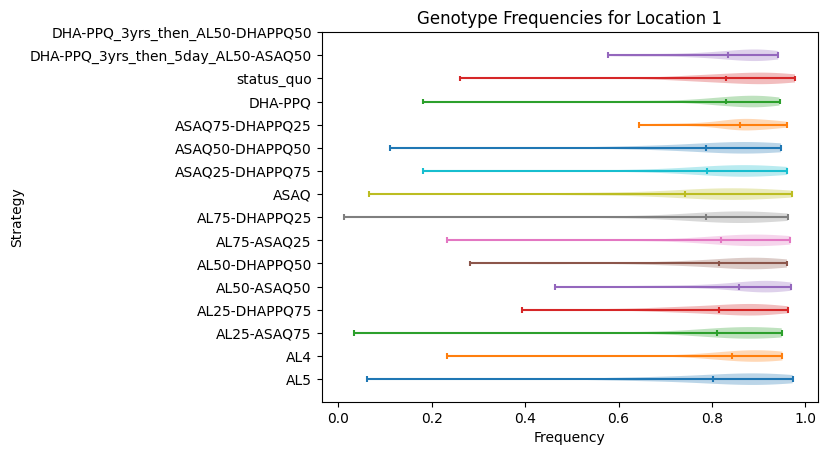

In [5]:
# Create a violin plot for a given genotype based on the row in agg_fqy
fig, ax = plt.subplots()
locationid = 1
for i, strategy in enumerate(strategies):
    try:
        agg_fqy = aggregate_resistant_genome_frequencies(DATA_SOURCE, strategy, 'H', 325, locationid)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    except ValueError as e:
        print(e)
        continue
    except IndexError as e:
        print(e)
        continue
    try:
        ax.violinplot(agg_fqy, positions=[i], showmeans=True, orientation='horizontal')
    except Exception as e:
        print(e)
        print(f"Error plotting {strategy}")
        continue
title = "Genotype Frequencies"# for Location {locationid}"
if locationid > 0:
    title += f" for Location {locationid}"
ax.set_title(title)
ax.set_xlabel("Frequency")
ax.set_ylabel("Strategy")
ax.set_yticks(range(len(strategies)))
ax.set_yticklabels(strategies)
plt.savefig("genotype_frequencies_violins.png")
plt.show()

Next we want to create Figure 2 from the [zubpko23 paper](https://mol.ax/pdf/zupko23b.pdf). Rather, than compare treatments, let's just do the results for one treatment per plot. 

Plot the following:
1. Number of treamtment failures plus 90% confidence interval
2. Resistant genometypes plus 90% confidence interval
3. PfPR2-10 (twelve month smoothed malaria prevelance in children 2-10 years old)

Plots are over ten years from when the treatment was started.

In [6]:
def plot_combined_strategy_aggragated_results(path: str, strategy: str, allele: str = 'H', locationid: int = -1):
    """
    Plots the treatment failure rate and the frequency of drug resistant genotypes for a given strategy

    Args:
    path (str): path to directory containing results files
    strategy (str): strategy to plot
    allele (str): allele to filter by, defaults to 'H'
    locationid (int): locationid to filter by, defaults to -1 which returns all locations

    Returns:
    plt.Figure: matplotlib figure
    """
    # Assert that the location is valid
    if locationid < 0:
        raise ValueError("locationid must be a positive integer")
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")
    # Get all results files in the path
    results_files = glob.glob(os.path.join(path, f"{strategy}_*.db"))
    if len(results_files) == 0:
        raise FileNotFoundError(f"No results files found for strategy {strategy}")
    agg = aggregate_resistant_genome_frequencies_by_month(path, strategy, allele, locationid)
    treatment_failures = aggregate_failure_rates(path, strategy, locationid)
    
    fig, ax = plt.subplots()
    ax.plot(agg.index / 12, agg['mean'], label='Mean', color='r')
    ax.plot(agg.index / 12, agg['median'], label='Median', color='r', alpha=0.5)
    ax.fill_between(agg.index / 12, agg['5th'], agg['95th'], color='r', alpha=0.15, label='5th-95th percentile')

    ax.plot(treatment_failures.index / 12, treatment_failures['mean'], label='Mean', color='b')
    ax.plot(treatment_failures.index / 12, treatment_failures['median'], label='Median', color='b', alpha=0.5)
    ax.fill_between(treatment_failures.index / 12, treatment_failures['5th'], treatment_failures['95th'], color='b', alpha=0.15, label='5th-95th percentile')

    ax.set_title(f"{strategy} Treatment Failure Rate and {allele} Resistant Genotype Frequency")
    ax.set_xlabel("Years")
    ax.set_ylabel("Frequency")
    ax.legend()

    return fig

Aggregating data for strategy AL5 with 45 files
Aggregating data for strategy AL5 with 45 files


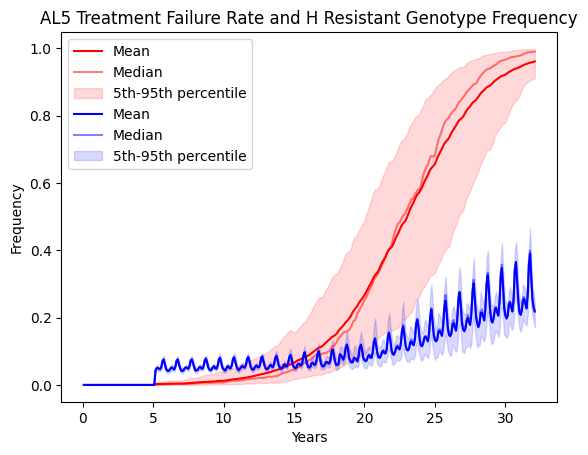

Aggregating data for strategy AL4 with 45 files
Aggregating data for strategy AL4 with 45 files


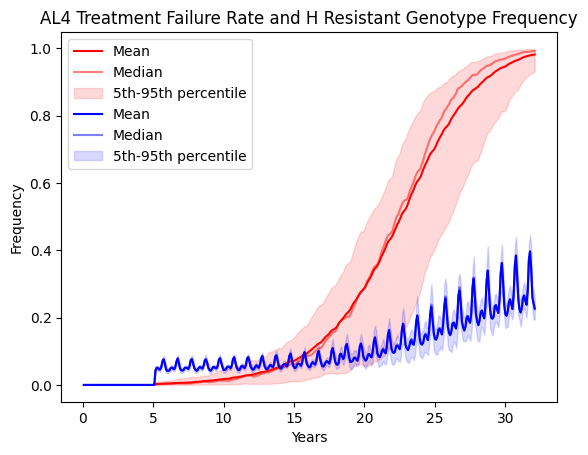

Aggregating data for strategy AL25-ASAQ75 with 41 files
Aggregating data for strategy AL25-ASAQ75 with 41 files


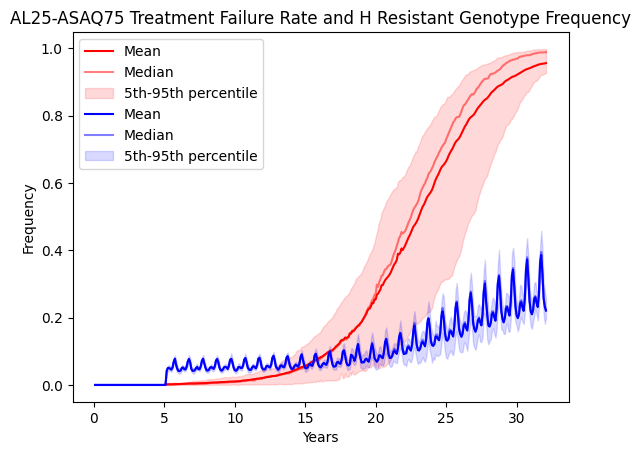

Aggregating data for strategy AL25-DHAPPQ75 with 45 files
Aggregating data for strategy AL25-DHAPPQ75 with 45 files


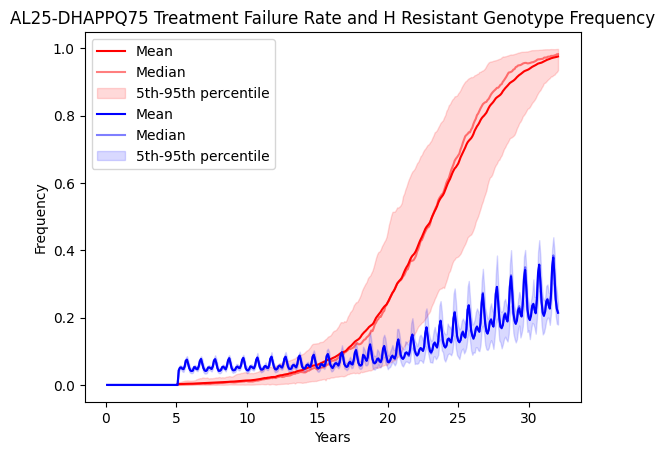

Aggregating data for strategy AL50-ASAQ50 with 45 files
Aggregating data for strategy AL50-ASAQ50 with 45 files


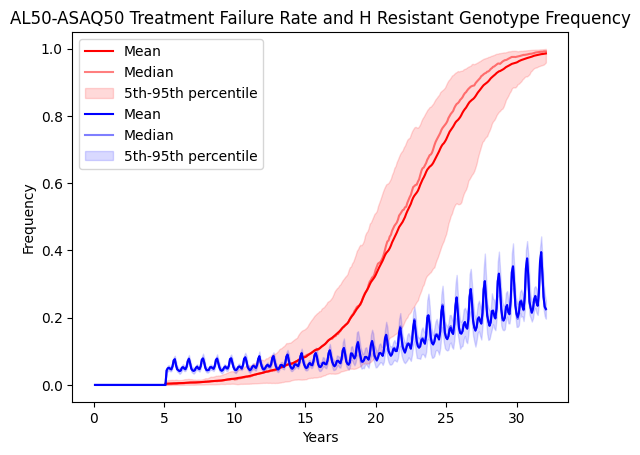

Aggregating data for strategy AL50-DHAPPQ50 with 45 files
Aggregating data for strategy AL50-DHAPPQ50 with 45 files


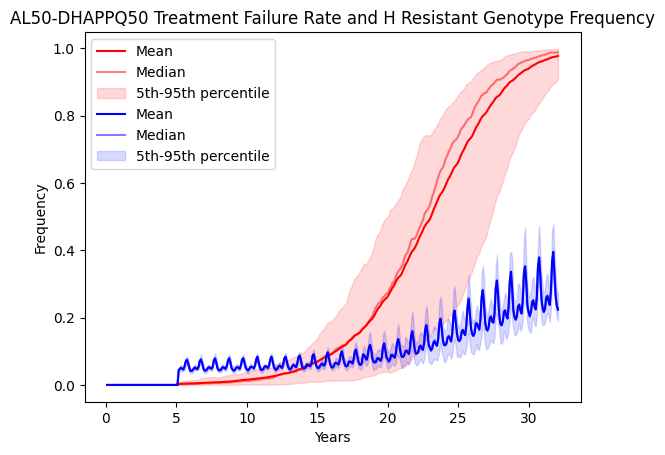

Aggregating data for strategy AL75-ASAQ25 with 45 files
Aggregating data for strategy AL75-ASAQ25 with 45 files


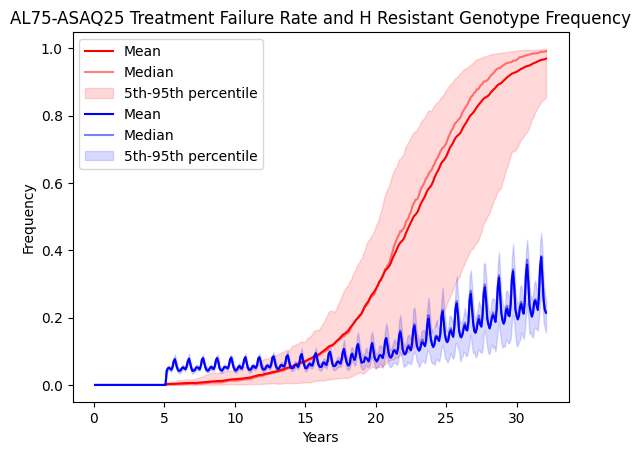

Aggregating data for strategy AL75-DHAPPQ25 with 45 files
Aggregating data for strategy AL75-DHAPPQ25 with 45 files


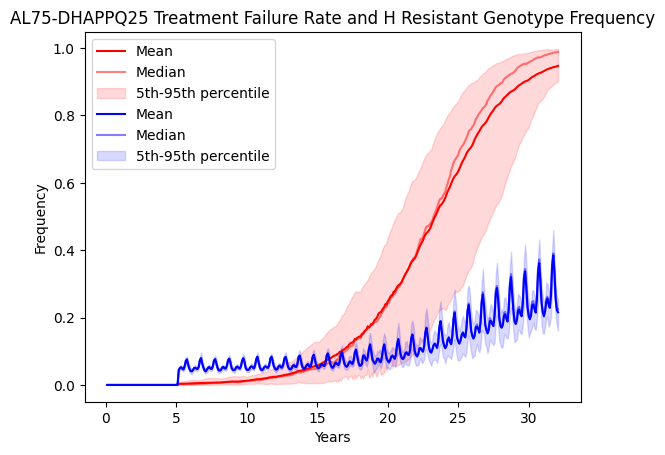

Aggregating data for strategy ASAQ with 45 files
Aggregating data for strategy ASAQ with 45 files


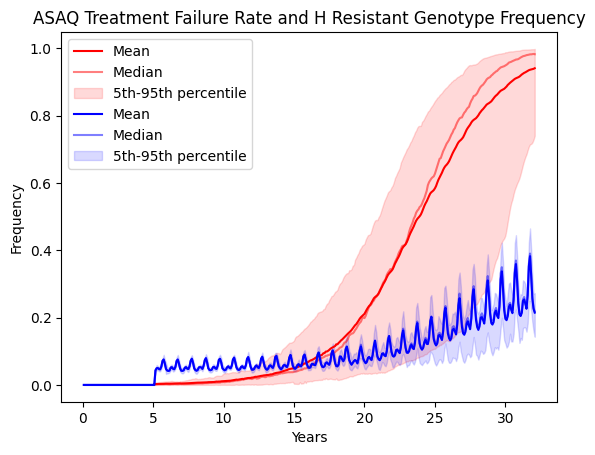

Aggregating data for strategy ASAQ25-DHAPPQ75 with 44 files
Aggregating data for strategy ASAQ25-DHAPPQ75 with 44 files


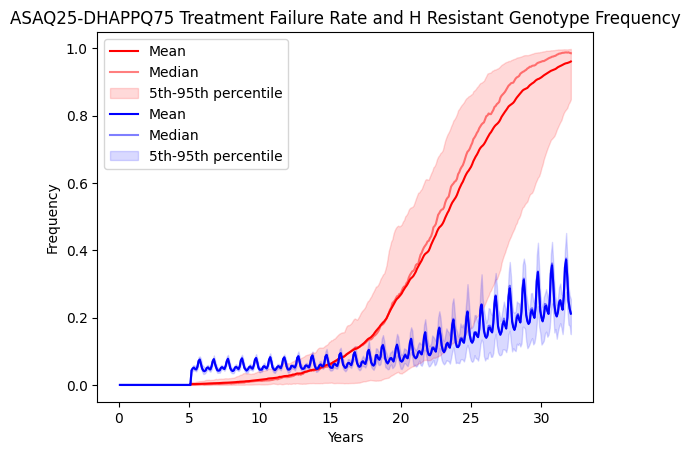

Aggregating data for strategy ASAQ50-DHAPPQ50 with 44 files
Aggregating data for strategy ASAQ50-DHAPPQ50 with 44 files


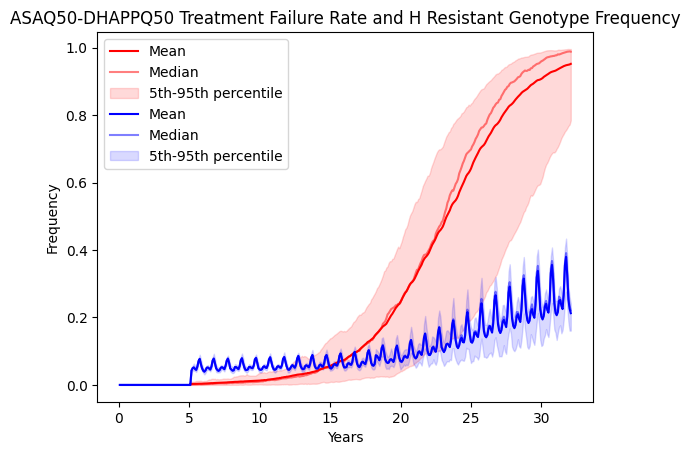

Aggregating data for strategy ASAQ75-DHAPPQ25 with 36 files
Aggregating data for strategy ASAQ75-DHAPPQ25 with 36 files


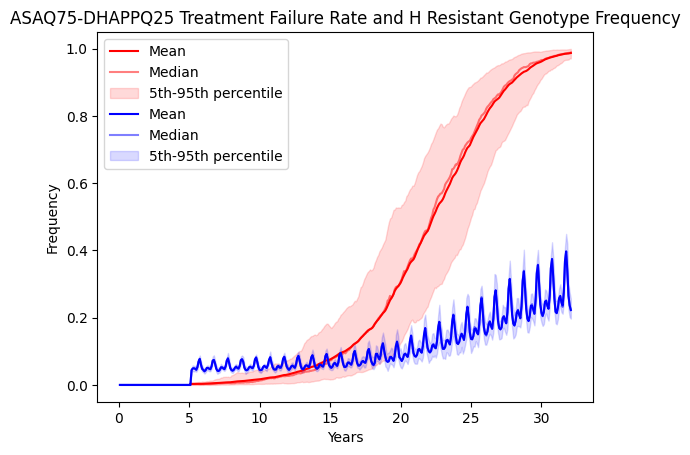

Aggregating data for strategy DHA-PPQ with 105 files


/tmp/ipykernel_58740/3764920540.py:373: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  genome_frequencies[file] = fqy
/tmp/ipykernel_58740/3764920540.py:373: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  genome_frequencies[file] = fqy
/tmp/ipykernel_58740/3764920540.py:373: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe

Aggregating data for strategy DHA-PPQ with 105 files


/tmp/ipykernel_58740/3764920540.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  summary[file] = data_summary.sum(axis=1)
/tmp/ipykernel_58740/3764920540.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  summary[file] = data_summary.sum(axis=1)
/tmp/ipykernel_58740/3764920540.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

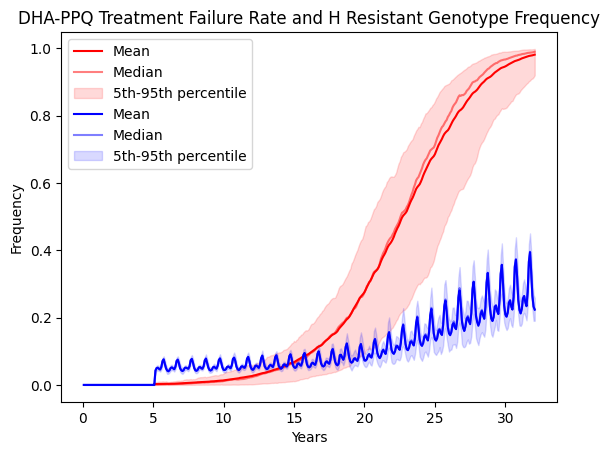

Aggregating data for strategy status_quo with 45 files
Aggregating data for strategy status_quo with 45 files


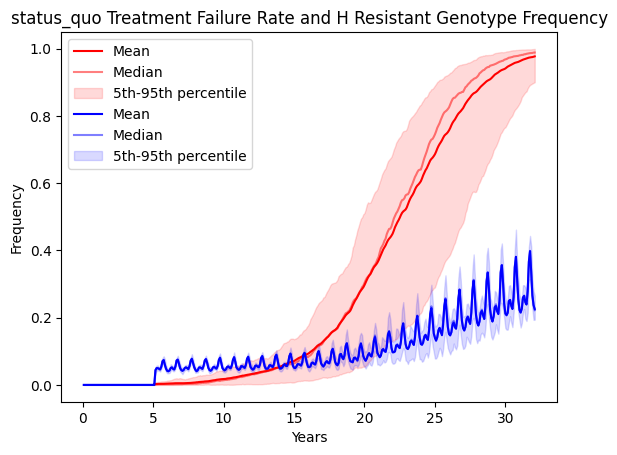

Aggregating data for strategy DHA-PPQ_3yrs_then_5day_AL50-ASAQ50 with 30 files
Aggregating data for strategy DHA-PPQ_3yrs_then_5day_AL50-ASAQ50 with 30 files


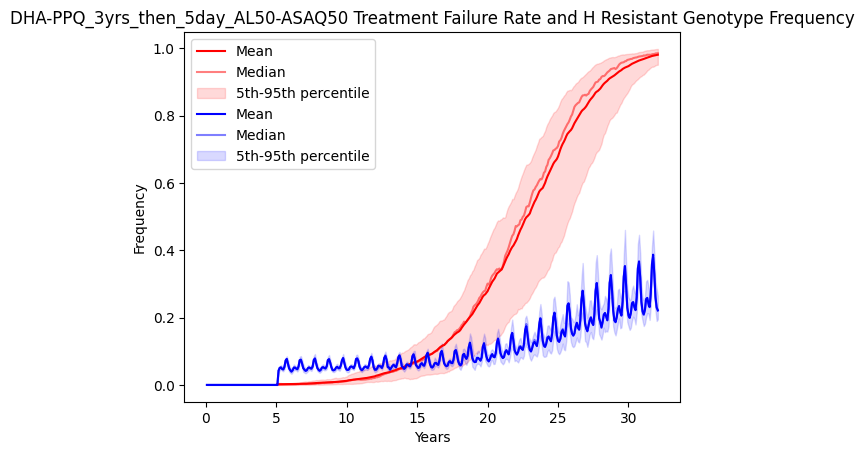

No results files found for strategy DHA-PPQ_3yrs_then_AL50-DHAPPQ50


In [7]:
for strategy in strategies:
    try:
        fig = plot_combined_strategy_aggragated_results(DATA_SOURCE, strategy, 'H', 1)
    except Exception as e:
        print(e)
        continue
    plt.savefig(f"{strategy}_combined.png")
    plt.show()
    plt.close(fig)